In [2]:
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os


In [3]:
folder_path = '../data/train/others/' # replace with your folder path
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select 10 images randomly or just the first 10 if there are not many
selected_images = image_files[:10]

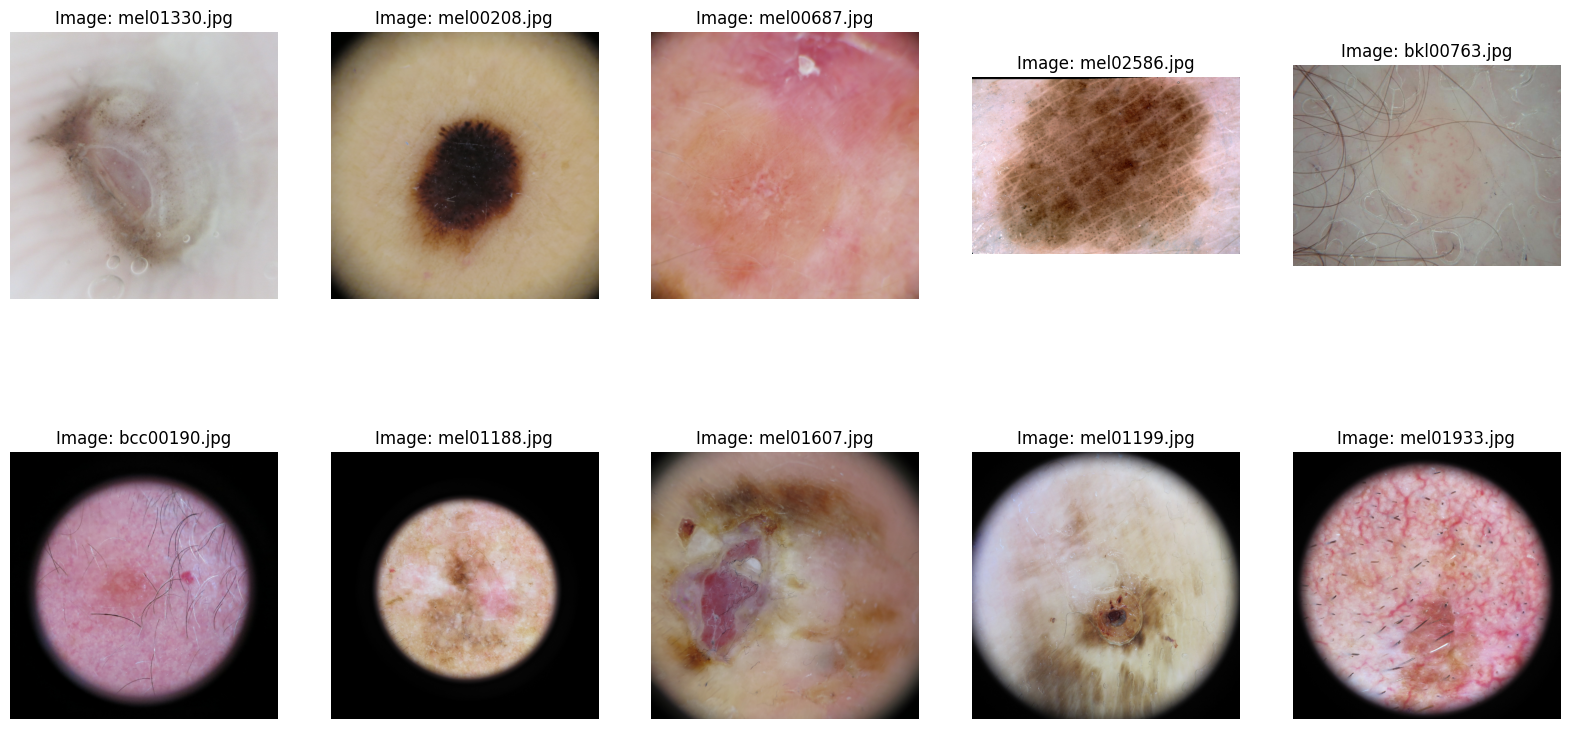

In [4]:
plt.figure(figsize=(20, 10))  # Adjust the size as needed

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)  # Adjust grid size (2 rows, 5 columns) based on number of images
    plt.imshow(img)
    plt.title(f"Image: {img_file}")
    plt.axis('off')

plt.show()

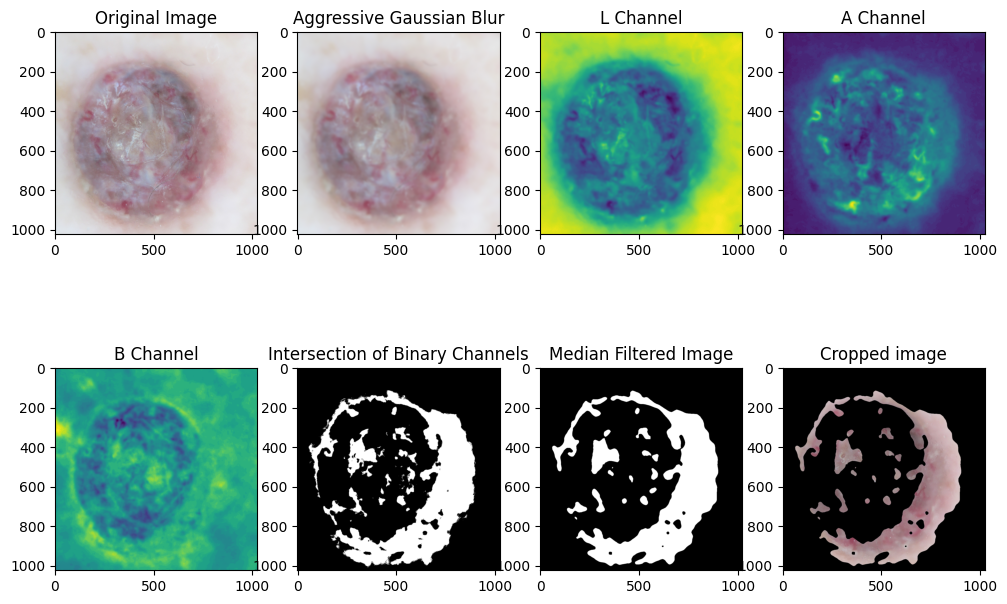

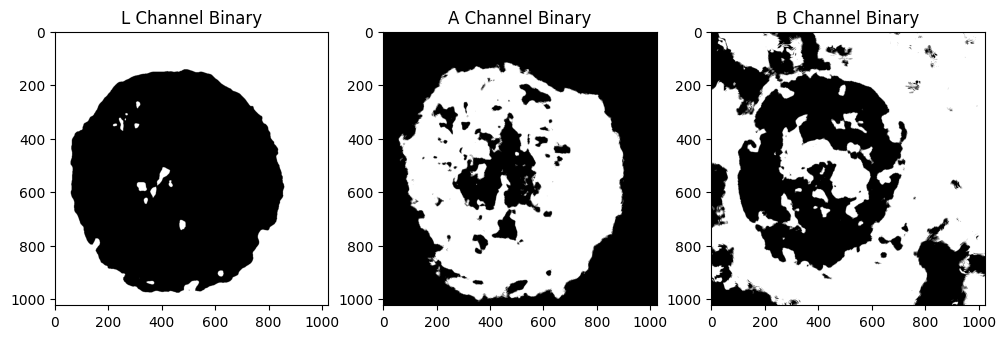

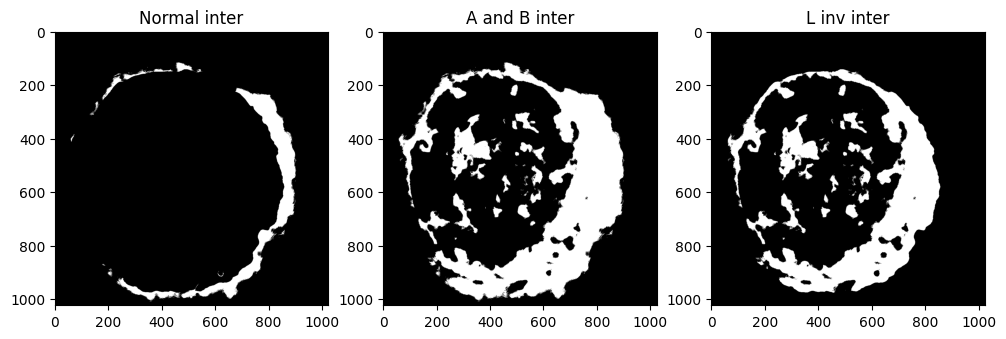

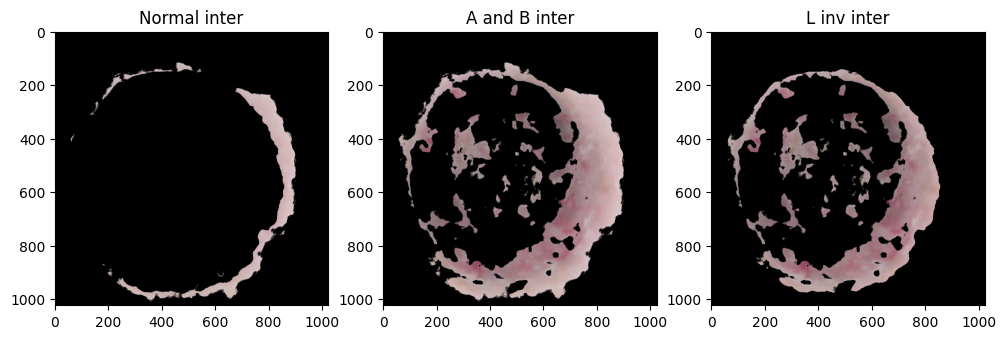

In [72]:
image = cv2.imread('../data/train/others/bcc00182.jpg')

# Step 1: Apply a more aggressive Gaussian filter to the image
gaussian_filtered = cv2.GaussianBlur(image, (25, 25), 0)

# Step 2: Convert the filtered image to LAB color space
lab_image = cv2.cvtColor(gaussian_filtered, cv2.COLOR_BGR2Lab)
# Step 3: Calculate the mean value of each LAB channel
l_mean = np.mean(lab_image[:, :, 0])
a_mean = np.mean(lab_image[:, :, 1])
b_mean = np.mean(lab_image[:, :, 2])

# Thresholding parameters
l_thresh = l_mean
a_thresh = a_mean
b_thresh = b_mean

# Threshold the LAB channels
_, l_binary = cv2.threshold(lab_image[:, :, 0], l_thresh, 255, cv2.THRESH_BINARY)
_, l_binary_inv = cv2.threshold(lab_image[:, :, 0], l_thresh, 255, cv2.THRESH_BINARY_INV)
_, a_binary = cv2.threshold(lab_image[:, :, 1], a_thresh, 255, cv2.THRESH_BINARY)
_, b_binary = cv2.threshold(lab_image[:, :, 2], b_thresh, 255, cv2.THRESH_BINARY)

# Step 4: Create an image with the intersection of the binary channels
intersection = cv2.bitwise_and(b_binary,cv2.bitwise_and(a_binary, l_binary))
intersection2 = cv2.bitwise_and(a_binary, b_binary)
intersection3 = cv2.bitwise_and(l_binary_inv,cv2.bitwise_and(a_binary, b_binary))

# Step 5: Apply a median filter with a 5x5 kernel to the intersection image
median_filtered = cv2.medianBlur(intersection2, 25)

# Step 9: Find contours in the binary image
contours, _ = cv2.findContours(median_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour by area
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    roi = median_filtered[y:y+250, x:x+250]
else:
    roi = median_filtered

# Plot the input and output images along with LAB channels
plt.figure(figsize=(12, 8))

plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(2, 4, 2)
plt.imshow(cv2.cvtColor(gaussian_filtered, cv2.COLOR_BGR2RGB))
plt.title('Aggressive Gaussian Blur')

plt.subplot(2, 4, 3)
plt.imshow(lab_image[:, :, 0])
plt.title('L Channel')

plt.subplot(2, 4, 4)
plt.imshow(lab_image[:, :, 1])
plt.title('A Channel')

plt.subplot(2, 4, 5)
plt.imshow(lab_image[:, :, 2])
plt.title('B Channel')

plt.subplot(2, 4, 6)
plt.imshow(intersection2, cmap='gray')
plt.title('Intersection of Binary Channels')

plt.subplot(2, 4, 7)
plt.imshow(median_filtered, cmap='gray')
plt.title('Median Filtered Image')

plt.subplot(2, 4, 8)
plt.imshow(cv2.cvtColor(cv2.bitwise_and(image, image, mask=median_filtered), cv2.COLOR_BGR2RGB))
plt.title('Cropped image')

plt.show()

# Plot the binary images for each channel
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(l_binary, cmap='gray')
plt.title('L Channel Binary')

plt.subplot(1, 3, 2)
plt.imshow(a_binary, cmap='gray')
plt.title('A Channel Binary')

plt.subplot(1, 3, 3)
plt.imshow(b_binary, cmap='gray')
plt.title('B Channel Binary')

plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(intersection, cmap='gray')
plt.title('Normal inter')

plt.subplot(1, 3, 2)
plt.imshow(intersection2, cmap='gray')
plt.title('A and B inter')

plt.subplot(1, 3, 3)
plt.imshow(intersection3, cmap='gray')
plt.title('L inv inter')

plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cv2.bitwise_and(image, image, mask=intersection), cv2.COLOR_BGR2RGB))
plt.title('Normal inter')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(cv2.bitwise_and(image, image, mask=intersection2), cv2.COLOR_BGR2RGB))
plt.title('A and B inter')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(cv2.bitwise_and(image, image, mask=intersection3), cv2.COLOR_BGR2RGB))
plt.title('L inv inter')

plt.show()



In [61]:
import numpy as np
import cv2
import os
from tqdm.notebook import tqdm
import time


def mask_maker(image):
    gaussian_filtered = cv2.GaussianBlur(image, (25, 25), 0)
    lab_image = cv2.cvtColor(gaussian_filtered, cv2.COLOR_BGR2Lab)
    l_thresh = np.mean(lab_image[:, :, 0]) ; a_thresh = np.mean(lab_image[:, :, 1]) ; b_thresh = np.mean(lab_image[:, :, 2])
    _,l_binary = cv2.threshold(lab_image[:, :, 0], l_thresh, 255, cv2.THRESH_BINARY)
    _,a_binary = cv2.threshold(lab_image[:, :, 1], a_thresh, 255, cv2.THRESH_BINARY)
    _,b_binary = cv2.threshold(lab_image[:, :, 2], b_thresh, 255, cv2.THRESH_BINARY)
    intersection = cv2.bitwise_and(a_binary, b_binary)
    median_filtered = cv2.medianBlur(intersection, 25)
    result = cv2.bitwise_and(image, image, mask=median_filtered)
    return result

def get_masks_from_dir(root_directory,datatype):
    names_of_subfolders = os.listdir(root_directory)
    for folder in tqdm(names_of_subfolders,desc=f'Working on {root_directory}'):
        path = os.path.join(root_directory,folder)
        files_names = os.listdir(path)
        for file in tqdm(files_names,desc=f'Analyzing files in {folder}',leave=False):
            image = cv2.imread(os.path.join(path,file))
            mask = mask_maker(image)
            result_path = os.path.join('..','data_masks',datatype,folder,file)
            if not cv2.imwrite(result_path,mask):
                raise Exception("Could not write image")

In [74]:
get_masks_from_dir('../data/val/','val')

Working on ../data/val/:   0%|          | 0/2 [00:00<?, ?it/s]

Analyzing files in nevus:   0%|          | 0/1931 [00:00<?, ?it/s]

Analyzing files in others:   0%|          | 0/1865 [00:00<?, ?it/s]